In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import cell2location
import matplotlib as mpl
import seaborn as sns
import warnings

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

In [3]:
results_folder = './results/lymph_nodes_analysis/'
# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [4]:
adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

100%|██████████| 7.86M/7.86M [00:01<00:00, 4.89MB/s]
100%|██████████| 29.3M/29.3M [00:03<00:00, 9.97MB/s]
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

In [6]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [7]:
# Read data
#adata_ref = sc.read(
 #  f'./data/sc.h5ad',
 #   backup_url='https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad'
#)

  1%|▏         | 7.27M/527M [12:04<14:23:19, 10.5kB/s]
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


OSError: Unable to synchronously open file (truncated file: eof = 7618560, sblock->base_addr = 0, stored_eof = 552080848)

In [9]:
adata_ref = sc.read( f'./data/sc.h5ad')

In [10]:
adata_ref.var['SYMBOL'] = adata_ref.var.index
# rename 'GeneID-2' as necessary for your data
adata_ref.var.set_index('GeneID-2', drop=True, inplace=True)

# delete unnecessary raw slot (to be removed in a future version of the tutorial)
del adata_ref.raw

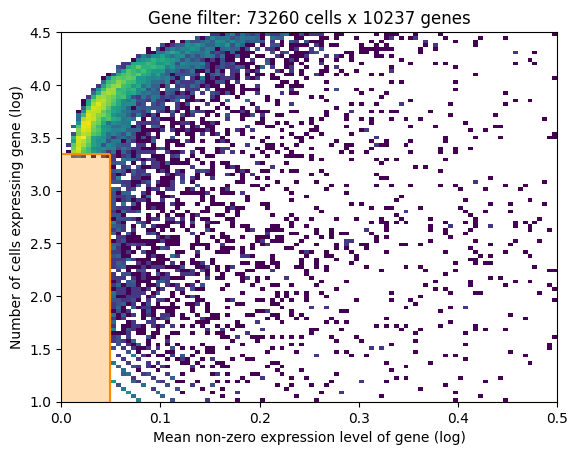

In [11]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [12]:
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='Sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='Subset',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['Method']
                       )

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [13]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': 'Subset',
│   'categorical_covariate_keys': ['Method'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  23   │
│         n_cells          │ 73260 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  34   │
│          n_vars          │ 10237 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                         batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │    4861STDY7135913     │          0          │
│                     │    4861STDY7135914     │          1          │
│                     │    4861STDY7208412     │          2          │
│                     │    4861STDY7208413     │          3          │
│                     │    4861STDY7462253     │          4          │
│                     │    4861STDY7462254     │          5          │
│                     │    4861STDY7462255     │          6          │
│                     │    4861STDY7462256     │          7          │
│                     │    4861STDY7528597     │          8          │
│                     │    4861STDY7528598     │          9          │
│                     │    4861STDY7528599     │         10          │
│                     │    4861STDY7528600     │         11          │
│                     │      BCP002_Total      │         12          │
│                     │      BCP003_Total      │         13          │
│                     │      BCP004_Total      │         14          │
│                     │      BCP005_Total      │         15          │
│                     │      BCP006_Total      │         16          │
│                     │      BCP008_Total      │         17          │
│                     │      BCP009_Total      │         18          │
│                     │ Human_colon_16S7255677 │         19          │
│                     │ Human_colon_16S7255678 │         20          │
│                     │ Human_colon_16S8000484 │         21          │
│                     │      Pan_T7935494      │         22          │
└─────────────────────┴────────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Subset'] │    B_Cycling     │          0          │
│                     │     B_GC_DZ      │          1          │
│                     │     B_GC_LZ      │          2          │
│                     │    B_GC_prePB    │          3          │
│                     │      B_IFN       │          4          │
│                     │   B_activated    │          5          │
│                     │      B_mem       │          6          │
│                     │     B_naive      │          7          │
│                     │     B_plasma     │          8          │
│                     │     B_preGC      │          9          │
│                     │     DC_CCR7+     │         10          │
│                     │     DC_cDC1      │         11          │
│                     │     DC_cDC2      │         12          │
│                     │      DC_pDC      │         13          │
│                     │       Endo       │         14          │
│                     │       FDC        │         15          │
│                     │       ILC        │         16          │
│                     │  Macrophages_M1  │         17          │
│                     │  Macrophages_M2  │         18          │
│                     │       Mast       │         19          │
│                     │    Monocytes     │         20          │
│                     │        NK        │         21          │
│                     │       NKT        │         22          │
│                     │      T_CD4+      │         23          │
│                     │    T_CD4+_TfH    │         24          │
│                     │  T_CD4+_TfH_GC   │         25          │
│                     │   T_CD4+_naive   │         26          │
│                     │  T_CD8+_CD161+   │         27          │
│                     │ T_CD8+_cytotoxic │         28          │
│                     │   T_CD8+_naive   │         29          │
│                     │     T_TIM3+      │         30          │
│                     │      T_TfR       │         31          │
│                     │      T_Treg      │         32          │
│                     │       VSMC       │         33          │
└─────────────────────┴──────────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Method'] │    3GEX    │          0          │
│                     │    5GEX    │          1          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

In [ ]:
help(mod.train)
mod.train(max_epochs=150, batch_size=2500,train_size=1,lr=0.002,use_gpu=True)

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Help on method train in module cell2location.models.reference._reference_model:

train(max_epochs: Optional[int] = None, batch_size: int = 2500, train_size: float = 1, lr: float = 0.002, **kwargs) method of cell2location.models.reference._reference_model.RegressionModel instance
    Train the model with useful defaults
    
    Parameters
    ----------
    max_epochs
        Number of passes through the dataset. If `None`, defaults to
        `np.min([round((20000 / n_cells) * 400), 400])`
    train_size
        Size of training set in the range [0.0, 1.0].
    batch_size
        Minibatch size to use during training. If `None`, no minibatching occurs and all
        data is copied to device (e.g., GPU).
    lr
        Optimiser learning rate (default optimiser is :class:`~pyro.optim.ClippedAdam`).
        Specifying optimiser via plan_kwargs overrides this choice of lr.
    kwargs
        Other arguments to scvi.model.base.PyroSviTrainMixin().train() method



/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 27/150:  17%|█▋        | 26/150 [03:32<16:44,  8.10s/it, v_num=1, elbo_train=2.92e+8]

In [ ]:
adata_ref = mod.export_posterior(
    adata_ref, use_quantiles=True,
    # choose quantiles
    add_to_obsm=["q05","q50", "q95", "q0001"],
    sample_kwargs={'batch_size': 2500, 'use_gpu': True}
)

In [ ]:
mod.plot_QC()

In [ ]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

In [ ]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [ ]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

In [ ]:
od.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

In [ ]:
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

In [ ]:
mod.plot_QC()

In [ ]:
fig = mod.plot_spatial_QC_across_batches()

In [ ]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['B_Cycling', 'B_GC_LZ', 'T_CD4+_TfH_GC', 'FDC',
                         'B_naive', 'T_CD4+_naive', 'B_plasma', 'Endo'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

In [ ]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['T_CD4+_naive', 'B_naive', 'FDC']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )

In [ ]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

In [ ]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)

In [ ]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(11, 13), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

In [ ]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()

In [ ]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

In [ ]:
# list cell types and genes for plotting
ctypes = ['T_CD4+_TfH_GC', 'T_CD4+_naive', 'B_GC_LZ']
genes = ['CD3D', 'CR2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

    from tutorial_utils import plot_genes_per_cell_type
    plot_genes_per_cell_type(slide, genes, ctypes);


In [ ]:
# Get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples=1000, use_gpu=True, return_samples=True,
                                    batch_size=2020,
                                    return_sites=['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)
samples_w_sf['posterior_samples']['w_sf'].shape

In [ ]:
# Compute any quantile of the posterior distribution
medians = mod.posterior_quantile(q=0.5, batch_size=mod.adata.n_obs, use_gpu=True)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), mod.samples['post_sample_means']['w_sf'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');

In [ ]:
cell2location.utils.list_imported_modules()